In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import os, h5py
import tensorflow as tf

from tqdm import tqdm
from numba import njit

from msfm.utils.input_output import read_yaml

### constants

In [2]:
conf_dir = "../../configs/config.yaml"
conf = read_yaml(conf_dir)

n_side = conf["analysis"]["n_side"]
n_pix = conf["analysis"]["n_pix"]

pixels_file = f"../../data/DESY3_pixels_{n_side}.h5"
noise_file = f"../../data/DESY3_noise.h5"

### load example map

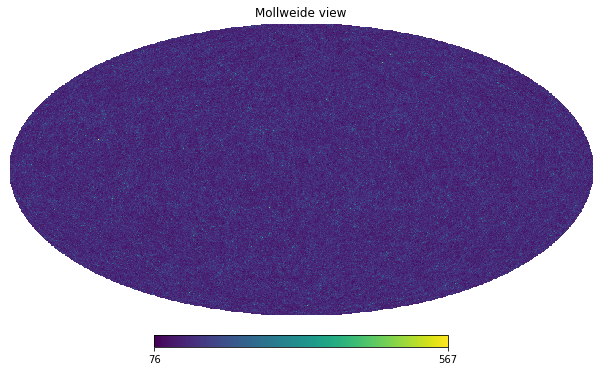

In [11]:
map_file = "/Users/arne/data/CosmoGrid_example/DES/grid/cosmo_000001/perm_0000/projected_probes_maps_nobaryons512.h5"
with h5py.File(map_file, "r") as f:
    dg = f["dg/desy3metacal1"][:]

n_bar = 68
bias = 1

count_map = n_bar * (1 + bias * dg)
count_map = np.where(0 < count_map, count_map, 0)
count_map = np.random.poisson(count_map)

hp.mollview(count_map)

In [20]:
pixel_file = "/Users/arne/git/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5"
with h5py.File(pixel_file, "r") as f:
    # print(f["metacal/masks/RING/desy3metacal1"].keys())
    mask = f["metacal/masks/RING/desy3metacal1"][:]

In [21]:
count_patch = count_map[mask]

### numpy

In [25]:
%%timeit
seg_ids = []
for id, n_gals in enumerate(count_patch):
    seg_ids.extend(n_gals*[id])

309 ms ± 1.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
len(seg_ids)

50619516

### tensorflow

In [28]:
%%timeit
i = tf.constant(0)
inds = []
cond = lambda i, count_patch: tf.less(i, count_patch.shape[0])
def body(i, count_patch):
    n_gals = count_patch[i]
    inds.extend(n_gals * [i])

    i = i + 1

    return (i, count_patch)

tf.while_loop(cond, body, [i, count_patch])

inds = tf.concat(inds, 0)

15.7 s ± 215 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
@tf.function
def tf_loop(count_patch):
    i = tf.constant(0)
    inds = []
    cond = lambda i, count_patch: tf.less(i, count_patch.shape[0])
    def body(i, count_patch):
        n_gals = count_patch[i]
        inds.extend(n_gals * [i])

        i = i + 1

        return (i, count_patch)

    tf.while_loop(cond, body, [i, count_patch])

    inds = tf.concat(inds, 0)

    return inds

In [30]:
tf_loop(count_patch)

OperatorNotAllowedInGraphError: in user code:

    File "/var/folders/kb/v2r9bm1s66j0d36jwj3xc6vm0000gn/T/ipykernel_81615/2192278015.py", line 8, in body  *
        inds.extend(n_gals * [i])

    OperatorNotAllowedInGraphError: iterating over `tf.Tensor` is not allowed: AutoGraph did convert this function. This might indicate you are trying to use an unsupported feature.


In [31]:
@tf.function(input_signature=(tf.TensorSpec(shape=[None], dtype=tf.int32),))
def g(x):
  print('Tracing with', x)
  return x

print(g(tf.constant([1, 2, 3])))
print(g(tf.constant([1, 2, 3, 4, 5])))


Tracing with Tensor("x:0", shape=(None,), dtype=int32)
tf.Tensor([1 2 3], shape=(3,), dtype=int32)
tf.Tensor([1 2 3 4 5], shape=(5,), dtype=int32)


2022-10-18 16:02:05.453584: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [47]:
N = int(1e7)
A = tf.ones(shape=(N,), dtype=tf.float32)
B = tf.random.uniform(shape=(N,), dtype=tf.float32)

def sum_tensor(A, B):
    A = tf.multiply(A, B)
    return tf.reduce_sum(A)

@tf.function(input_signature=[tf.TensorSpec(shape=(N,), dtype=tf.float32), tf.TensorSpec(shape=(N,), dtype=tf.float32)])
def tf_sum_tensor(A, B):
    print("Tracing tf_sum_tensor")
    A = tf.multiply(A, B)

    return tf.reduce_sum(A)

@tf.function(input_signature=[tf.TensorSpec(shape=(None,), dtype=tf.float32), tf.TensorSpec(shape=(None,), dtype=tf.float32)])
def tf_sum_tensor_none(A, B):
    A = tf.multiply(A, B)
    print("Tracing tf_sum_tensor_none")
    return tf.reduce_sum(A)


In [45]:
%%timeit
sum_tensor(A, B)

477 µs ± 11 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [48]:
%%timeit
tf_sum_tensor(A, B)

Tracing tf_sum_tensor


2022-10-19 08:22:26.441478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


469 µs ± 3.15 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [59]:
%%timeit
leave_id = np.random.choice(100)
tf_sum_tensor_none(A[:-leave_id], B[:-leave_id])

2.05 ms ± 110 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [60]:
%%timeit
leave_id = np.random.choice(100)
sum_tensor(A[:-leave_id], B[:-leave_id])

1.81 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [62]:
print(
    "hallo "
    "test"
)

hallo test
